# 4. Модельные данные

### Подключение необходимых библиотек

In [14]:
import numpy as np
import pandas as pd
import statistics as sts
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import math

### Фиксирование данных 

In [15]:
# Объем выборки значений за год
n_days = 252
# Количество испытаний
n_iter = 10000
# Параметры нормального распределения
loc = 0
scale = 1
# Уровень значимости
alpha = 0.05
# Пустой список P-значений
p_values_list = []

### Функция для оценки параметров $\mu$ и $\sigma$ получаемой выборки 

In [16]:
def param_estimation(sample):
    # Сортируем по возрастанию полученную выборку 
    sample.sort()
    # Объём выборки
    length = len(sample)
    # Считаем количество интервалов, на которые мы разобьём выборку
    log = math.log2(len(sample))
    k = int(1 + log)
    # Создаём список для центральных точек для каждого полученного интервала
    cpoint = [min(sample)]
    # Определяем шаг для прохождению по выборке
    step = (max(sample) - min(sample))/k
    
    # Создаём список для данных для каждого полученного интервала
    segment_list = []
    # Заполняем созданный список
    segment_list.append([part for part in sample if part < step/2 + cpoint[-1]])
    for i in range(1, k):
        cpoint.append(cpoint[0] + step * (i-1))
        segment_list.append([x for x in sample if cpoint[-1] - step/2 < x < cpoint[-1] + step/2])
    cpoint.append(cpoint[0] + step * (k - 1))    
    segment_list.append([part for part in sample if part > cpoint[-1] - step/2])
    
    # Получаем список частот (кол-ва элементов в каждом интервале)
    freq = [len(part) for part in segment_list]
    
    # Считаем значение мат.ожидания в 1-м приближении (по формуле из теор.справки)
    loc = 0
    for value in range(len(freq)):
        loc += freq[value] * cpoint[value]
    loc = loc/length
    
    # Считаем значение ст.отклонения в 1-м приближении (по формуле из теор.справки)
    scale = 0
    for value in range(len(freq)):
        scale += freq[value] * (cpoint[value] - loc)**2
    scale = (scale/length)**(1/2)
    
    # Вывод мат.ожидания, ст.отклонения, списка частот и списка центр.точек
    return loc, scale, freq, cpoint

### Функция для вычисления статистики и P-значения критерия χ² Пирсона

In [17]:
def ChiSquare(n_days):
    # Генерируем выборку из нормального распределения объемом n
    sample = np.random.normal(loc, scale, size=n_days)
    # Считаем количество интервалов, на которые мы разобьём выборку
    log = math.log2(len(sample))
    k = int(1 + log)
    # Определяем шаг для прохождению по выборке
    step = (max(sample) - min(sample))/k
    # Получаем необходимые характеристики 
    mu, sigma, frequency, cpoint = param_estimation(sample)
    # Создаём распределение для сравнения его со случайной выборкой 
    expected = stats.norm(mu, sigma)
    
    # Создаём список вероятностей попадания значений в полученные интервалы
    p_list = []
    # Заполняем созданный список
    p_list.append(expected.cdf(cpoint[0] + step/2))
    for value in range(1, len(cpoint)-1):
        p_list.append((expected.cdf(cpoint[value] + step/2)-expected.cdf(cpoint[value] - step/2)))
    p_list.append(1-expected.cdf(cpoint[-1] - step/2))

    # Получения статистики χ²
    chi_sqare_stat = 0
    # Создаём список для заполнения i-ми статистиками
    statistics_list = []
    for i in range(len(p_list)):
        statistics_list.append(((frequency[i] - n_days * p_list[i])**2) / (n_days * p_list[i]))
        chi_sqare_stat += statistics_list[i]
    # Получения p-values χ²
    chi_sqare_pvalue = (stats.chi2(len(frequency)-3).sf(chi_sqare_stat))
    
    # Вывод статистики и P-значения критерия χ²
    return chi_sqare_stat, chi_sqare_pvalue

### Нахождение квантилей

In [18]:
# Создаём пустые DataFrame-ы для заполнения квантилями
q9_df, q999_df = pd.DataFrame(), pd.DataFrame()

# Вычисляем значения статистики 10.000 раз
chi_sqare_test = [ChiSquare(n_days) for i in range(n_iter)]

# Заполняем списки значений статистики и p-значений χ²
statistics_list =  [x[0] for x in chi_sqare_test]
p_values_list = [x[1] for x in chi_sqare_test]
    
# Вычисление квантилей статистики
quantiles_999 = np.quantile(statistics_list, np.arange(0.001, 1, 0.001))
quantiles_9 = np.quantile(statistics_list, np.arange(0.1, 1, 0.1))
    
# Вычисление квантилей p-значений
pv_quantiles_999 = np.quantile(p_values_list, np.arange(0.001, 1, 0.001))
    
# Формирование DataFrame 9 квантилей статистики
q9_df['Quantile'] = [value for value in list(np.arange(0.1, 1, 0.1))]
q9_df['Value'] = np.round(quantiles_9,6)
q9_df.set_index('Quantile',inplace = True)

# Формирование DataFrame 999 квантилей статистики
q999_df['Quantile'] = [value for value in list(np.arange(0.001, 1, 0.001))]
q999_df['Value'] = np.round(quantiles_999,6)
q999_df.set_index('Quantile',inplace = True)

### 9 квантилей статистики

In [19]:
# q9_df - Вывод таблицы 9 квантилей статистики

### Сохраним данные в csv-файле 

In [20]:
path_first = "Таблица 5. Значения статистики модельных данных.csv"
path_second = f"Таблица 6. 999 квантилей модельных данных, n = {n_days}.csv"
path_third = f"Таблица 7. 9 квантилей модельных данных, n = {n_days}.csv"

def wr_csv(path, data, name, quantity):
    line = [[name]]
    with open(path, "w", newline='') as csv_file:
        writer = csv.writer(csv_file,delimiter=';')
        writer.writerows(line)
        for i in  range(quantity):
            line = [[]]
            if name== '999 Квантилей': line[0].append(str((i+1)/1000).replace('.', ','))
            if name== '9 Квантилей': line[0].append(str((i+1)/10).replace('.', ','))
            if name== '9 Квантилей': line[0].append(str((i+1)/10).replace('.', ','))
            line[0].append(str(data[i]).replace('.', ','))
            writer.writerows(line)

In [21]:
wr_csv(path_first, statistics_list, 'Значения статистики',n_days)
wr_csv(path_second, quantiles_999, '999 Квантилей',999)
wr_csv(path_third, quantiles_9, '9 Квантилей',9)

### Подготовка таблицы P-значений, вычисляемых вручную

In [22]:
# Вычисляем P-значения 10.000 раз
chi_sqare_test = [ChiSquare(n_days)[0] for i in range(n_iter)]
# Вычисление квантилей статистики
quantiles_999 = np.quantile(chi_sqare_test, np.arange(0.001, 1, 0.001))

# Пустой список для P-значений
p_values_list = []
# Функция для вычисления P-значений вручную
for iteration in range(n_iter):
    value_0 = ChiSquare(n_days)[0]
    counter = 0
    for value in range(len(quantiles_999)):
        if quantiles_999[value] > value_0: 
            counter = counter + 1
    p_values_list.append(counter/len(quantiles_999))

### Вывод гистограммы P-значений 

(array([0.973, 1.034, 0.965, 1.032, 1.104, 1.003, 0.978, 0.989, 0.992,
        0.93 ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

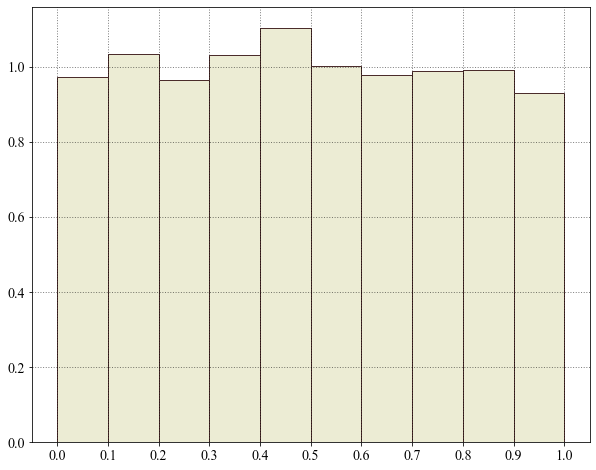

In [23]:
font = {'family': 'serif', 'serif': 'Times New Roman', 'weight': 'normal','size':14}
plt.rc('font',**font)

fig,ax = plt.subplots(figsize=(10, 8))
plt.xticks(np.linspace(0.0, 1.0, 11))
ax.grid(color='black', alpha=0.5, linestyle=':', linewidth=1)
plt.hist(p_values_list, color = '#ececd4', edgecolor = '#4b2c2b', density = True)

# plt.show() -  Вывод рисунков: Рис.5. Гистограмма P-значений – модельные данные

### Подготовка таблицы P-значений, вычисляемых по Критерию Колмогорова

In [24]:
# Тест Критерия Колмогорова
p_values_list_ks = []

for iteration in range(n_iter):
    # Генерация выборки из нормального распределения, размер = n
    sample = stats.norm(0, 1).rvs(n_days)
    p_values_list_ks.append(stats.kstest(sample,'norm')[1])

### Вывод гистограммы P-значений 

(array([1.02516294, 1.04716643, 0.94915085, 1.01916198, 0.9991588 ,
        0.98815705, 0.99615833, 1.01116071, 0.95715213, 1.00916039]),
 array([4.24247067e-05, 1.00026531e-01, 2.00010637e-01, 2.99994744e-01,
        3.99978850e-01, 4.99962956e-01, 5.99947063e-01, 6.99931169e-01,
        7.99915275e-01, 8.99899382e-01, 9.99883488e-01]),
 <BarContainer object of 10 artists>)

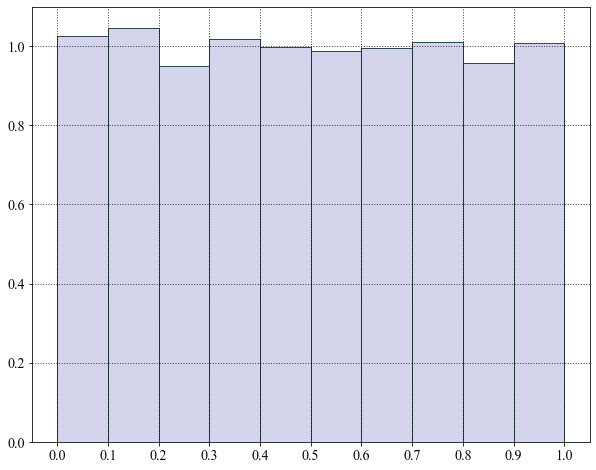

In [25]:
font = {'family': 'serif', 'serif': 'Times New Roman', 'weight': 'normal','size':14}
plt.rc('font',**font)

fig,ax = plt.subplots(figsize=(10, 8))
plt.xticks(np.linspace(0.0, 1.0, 11))
ax.grid(color='black', alpha=0.75, linestyle=':', linewidth=1)
plt.hist(p_values_list_ks, color = '#d4d4ec', edgecolor = '#2b4a4b', density = True)

# plt.show() -  Вывод рисунков: Рис.6. Гистограмма P-значений – модельные данные (Критерий Колмогорова)

In [26]:
# проверка, что распределения p-значений идентичны
p_value_test_ks = stats.kstest(p_values_list_ks,'uniform')
p_value_test_ks

KstestResult(statistic=0.008731319854970887, pvalue=0.4284567555424902)